In [1]:
%%time
# Imports
from utils import *

CPU times: total: 1.25 s
Wall time: 2.74 s


File-Reading

In [2]:
%%time

# Get start time
start = time.perf_counter()

# File-Reading
path = os.path.join(os.getcwd() , out_file) # from utils
user = []
ts = []
ca = []
tweets = []
mentions = []
coord = []
country = []

with open(path , 'r' , encoding='utf-8') as in_file:
    csv_reader = csv.reader(in_file , delimiter = "|")
    for line in csv_reader:
        user.append(line[0])
        ts.append(line[1])
        ca.append(line[2])
        tweets.append(line[3])
        mentions.append(line[4])
        coord.append(line[5])
        country.append(line[6])

CPU times: total: 23.1 s
Wall time: 23.2 s


In [3]:
%%time
# Convert timestamp to datetime format
ts_convert = [datetime.datetime.fromtimestamp(int(dt)//1000) for dt in ts]

twt_df = pd.DataFrame(
    list(zip(user , ts_convert , tweets)) , columns = ['user' , 'ts' , 'tweet_id']
)

twt_df = twt_df[twt_df['tweet_id']!="None"].drop_duplicates()
print(f'length of tweet df is {len(twt_df)}')

length of tweet df is 15033548
CPU times: total: 46.7 s
Wall time: 46.8 s


# **02 - USERS**
### **Question - 1**

In [4]:
%%time
twt_df_usr = twt_df.groupby('user').agg(num_twt = ('tweet_id' , 'nunique')).reset_index()

CPU times: total: 22 s
Wall time: 22 s


CPU times: total: 172 ms
Wall time: 160 ms


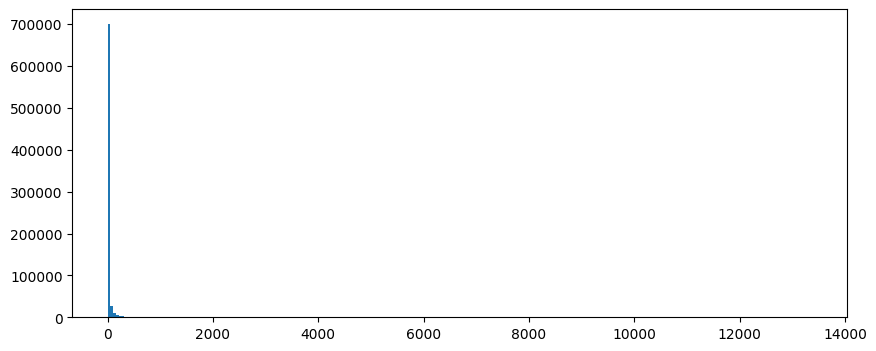

In [5]:
%%time
fig , ax = plt.subplots(figsize = (10 , 4));

freq , bins , patches = ax.hist(twt_df_usr.num_twt , bins = 250);

That's not very enlightening. Let's see if we can do better manually!

CPU times: total: 594 ms
Wall time: 589 ms


Text(0, 0.5, 'log10(number of users)')

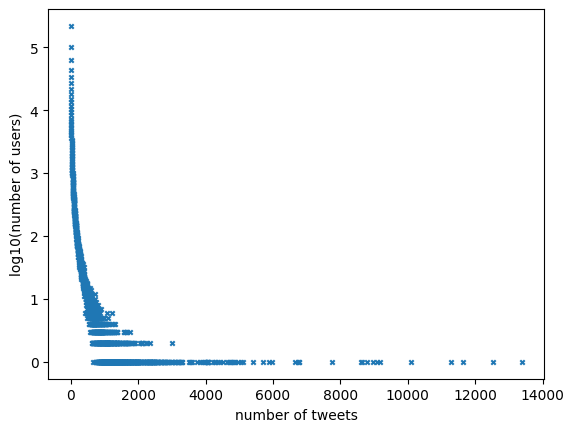

In [6]:
%%time
twt_df_usr_2 = twt_df_usr.groupby('num_twt').agg(users = ('user' , 'nunique')).reset_index()

# Applying log-log transformations on both
twt_df_usr_2['log_users'] = np.log10(twt_df_usr_2['users'])
twt_df_usr_2['log_twt'] = np.log10(twt_df_usr_2['num_twt'])

# Plot
fig , ax = plt.subplots()
ax.scatter(twt_df_usr_2['num_twt'] , twt_df_usr_2['log_users'] , s = 10 , marker = 'x');
ax.set_xlabel('number of tweets');
ax.set_ylabel('log10(number of users)');

We see that this plot roughly agrees with the histogram. It helps us understand that the majority of users tweet between $1$ and $2000$ times (we will return to quantifying this a little later). <br/>
However, there are *some* users who have tweeted over $10,000$ times, with the top user (by volume of tweets) having tweeted $13,376$ times! <br/>
Seeing that there are 30 days in our dataset, this user must have tweeted $\frac{13376}{30 \cdot 24} = 18.6$ times per hour, every hour of every day of the month. This is a bit ludicrous. <br/>

CPU times: total: 0 ns
Wall time: 11 ms


(-0.2, 6.0)

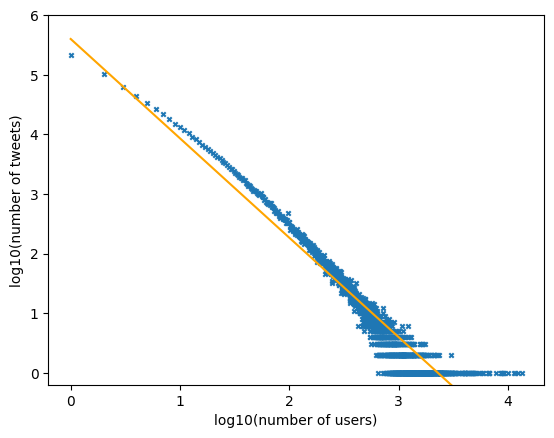

In [7]:
%%time
fig , ax = plt.subplots()
ax.scatter(twt_df_usr_2['log_twt'] , twt_df_usr_2['log_users'] , s = 10 , marker = 'x');
ax.set_xlabel('log10(number of users)');
ax.set_ylabel('log10(number of tweets)');

# Eyeballing the equation of the line
x = np.linspace(0 , 4)
y = (-5/3)*x + 5.6
ax.plot(x , y , color = 'orange')
plt.ylim(-0.2 , 6);

CPU times: total: 109 ms
Wall time: 121 ms


<AxesSubplot: xlabel='log_twt', ylabel='log_users'>

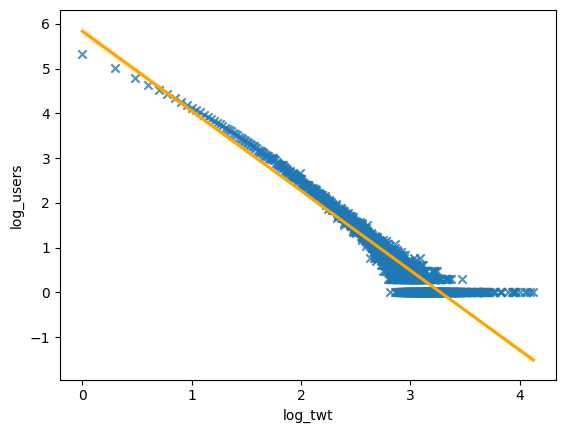

In [8]:
%%time
# Drawback with this is that it doesn't allow us to access the lin reg line!
sns.regplot(
    x = twt_df_usr_2['log_twt'] , y = twt_df_usr_2['log_users'] , 
    scatter = True , 
    fit_reg = True , 
    marker = 'x' , 
    line_kws = {'color' : 'orange'}
)

$$
Y = 5.6 -1.666X
\\
Knowing \ that\ Y = log_{10}y \ and\ X = log_{10}x,
\\
y = 10^{5.6}x^{-1.666}
$$

From this preliminary standpoint, these accounts appear to be bots, but more investigation is needed.

### **Question - 2**

In [9]:
%%time
twt_df_usr.sort_values('num_twt' , ascending=False).head(5)

CPU times: total: 109 ms
Wall time: 111 ms


,user,num_twt
199506,1402775770481713157,13376
267100,1491316688549253120,12518
736010,954732087235563520,11628
188394,1384110594,11294
27730,1069583615762288642,10087


More investigation is needed to peer into their behaviour. Names, post content and patterns of timestamps may be a good place to start!

In [10]:
%%time

#Create a day dataframe
day_df = pd.DataFrame(
    [
        [0 , 'Mon'],
        [1 , 'Tue'],
        [2 , 'Wed'],
        [3 , 'Thu'],
        [4 , 'Fri'],
        [5 , 'Sat'],
        [6 , 'Sun'],
    ] ,
    columns = ['day' , 'dayofweek']
)

twt_df['hour'] = twt_df['ts'].dt.hour
twt_df['day'] = twt_df['ts'].dt.day_of_week
twt_df = twt_df.merge(day_df , on = 'day' , how = 'inner')

CPU times: total: 4.06 s
Wall time: 4.08 s


In [11]:
def vis_hi_usage(df , users) -> [None]:
    '''
    simple visualization of anomalously voluminous tweeters
    params: df: dataframe; contains user tweets and timestamps
    params: users: list; intended user
    return: no return
    '''
    fig , axes = plt.subplots(len(users) , 1 , figsize = (20, 5))
    for _ , (ax , usr) in enumerate(zip(axes , users)):
        user = str(usr)
        
        df_user = df[df['user'] == user].copy()
        
        df_user['day_hr'] = df_user['day']*100+df_user['hour']
        df_user_2 = df_user.groupby('day_hr').agg(num_tweets = ('tweet_id' , 'nunique')).reset_index()
        df_user_2['day_hr'] = df_user_2['day_hr'].astype('str').str.zfill(4)
        
        ax.plot(df_user_2.day_hr , df_user_2.num_tweets , label = f'User {user}');
        ax.legend(loc = 'right');

CPU times: total: 11 s
Wall time: 10.9 s


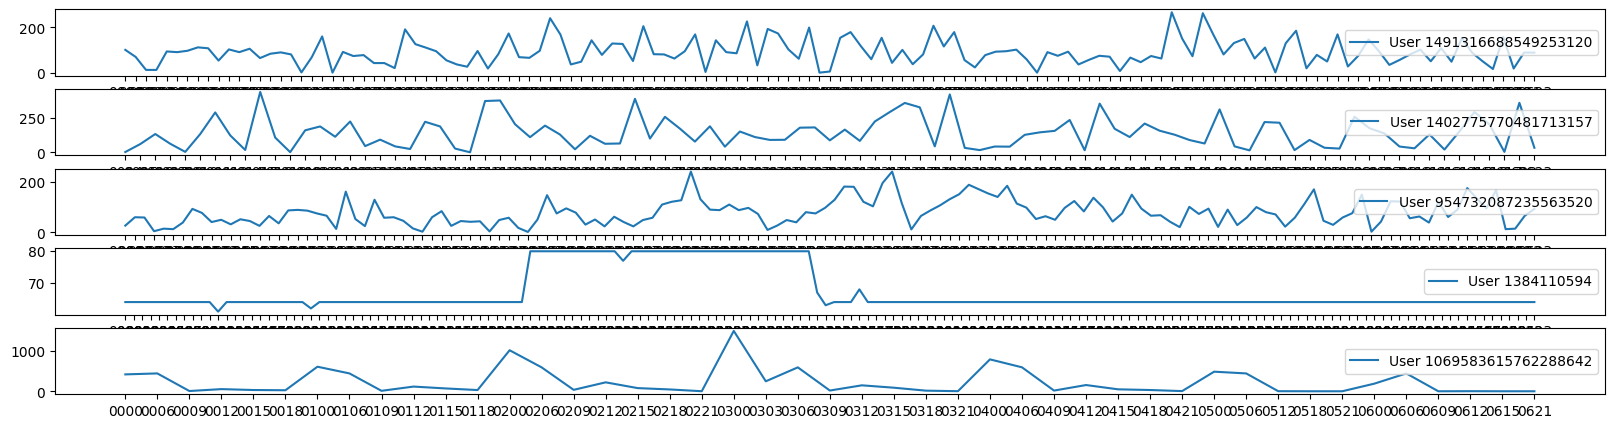

In [12]:
%%time

vis_hi_usage(df = twt_df, users = [1491316688549253120,1402775770481713157,954732087235563520,1384110594,1069583615762288642])

No discernable pattern, apart from maybe 1069583615762288642

### **Question-3**

In [13]:
%%time

# Make DF
twt_mentions_df = pd.DataFrame(
    list(zip(user , tweets , mentions , coord , ts_convert)) , 
    columns = ['user' , 'tweets' , 'mentions' , 'coord' , 'ts']
)
# Get rid of null values
twt_mentions_df = twt_mentions_df[twt_mentions_df['tweets']!='None']
# Get rid of duplicates
twt_mentions_df.drop_duplicates(inplace=True)

# Grouping to get top 5 users (in terms of number of mentions)
twt_mentions_df_2 = twt_mentions_df[twt_mentions_df['mentions']!="None"].groupby('mentions').agg(num_mentions = ('mentions' , 'count')).reset_index()
twt_mentions_df_2.sort_values('num_mentions', ascending=False).head(5)

CPU times: total: 1min 2s
Wall time: 1min 2s


,mentions,num_mentions
24406,10228272,15536
1619240,68034431,6610
1219355,2866804900,5460
787568,1503799593405800449,5413
1289919,3131144855,5385


*These highly mentioned accounts are probably:*
1. Celebrities/ Influencers
2. Political Figures
3. Companies/ Groups
_____________
**For example**<br/>
10228272 - YouTube<br/>
68034431 - Recep Tayyip Erdogan (President of Turkey)<br/>
2866804900 - SkylerFleur - Suspended Account<br/>
1503799593405800449 - Student Governing Council IIIT Basar - **QUESTION** Why are a bunch of tweets originating in India?<br/>
3131144855 - BoJo<br/>

CPU times: total: 1.89 s
Wall time: 1.89 s


Text(0, 0.5, 'log mentions')

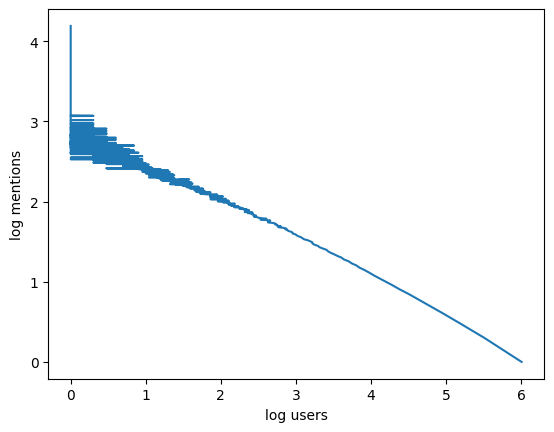

In [14]:
%%time

# Take log-log transform
twt_mentions_df_3 = twt_mentions_df_2.groupby('num_mentions').agg(users = ('mentions','nunique')).reset_index()
twt_mentions_df_3['log_users'] = np.log10(twt_mentions_df_3['users'])
twt_mentions_df_3['log_mentions'] = np.log10(twt_mentions_df_3['num_mentions'])

# Plot (probably useless since we're not going to do anything with this)
plt.plot(twt_mentions_df_3['log_users'] , twt_mentions_df_3['log_mentions']);
plt.xlabel('log users');
plt.ylabel('log mentions');

### **QUESTION - 4**
Choose 4 countries and compute how often they mention each other. This means you should compute 16 numbers e.g. UK mentions UK, UK mentions
France, France mentions UK etc. Comment on any patterns you observe. [5 marks]

In [15]:
%%time

# Make DF
twt_mentions_df = pd.DataFrame(
    list(zip(user , mentions , tweets , country)) , 
    columns = ['user' , 'mentions' , 'tweet_id' , 'country']
)

twt_mentions_df = twt_mentions_df[twt_mentions_df['tweet_id']!= "None"].drop_duplicates()
#twt_mentions_df = twt_mentions_df[twt_mentions_df['mentions']!= "None"] # Don't remove these now. We may need them for country identification later
print(f'the length of the df is {len(twt_mentions_df)}') # Turn this into an assertion check later!

# Trying to get one primary country per user - the country column is only attached to the user
twt_country = twt_mentions_df[['user' ,'country']].drop_duplicates()

prim_country = twt_country.groupby(['user','country']).agg(num_occr = ('user','count')).reset_index()

prim_country['max_occr_country'] = prim_country.groupby('user')['num_occr'].rank(method = "first" , ascending = False)
prim_country = prim_country[prim_country['num_occr'] == prim_country['max_occr_country']]

# Use dask to parallelize pandas stuff!
dask_mentions_df = from_pandas(twt_mentions_df, npartitions=8)
dask_user_country_df = from_pandas(prim_country , npartitions=8)

the length of the df is 15033548
CPU times: total: 1min 8s
Wall time: 1min 8s


In [16]:
del twt_mentions_df , twt_mentions_df_3 , twt_mentions_df_2 , twt_df , day_df , twt_df_usr , twt_df_usr_2 , ts_convert , twt_country , prim_country , user , mentions , tweets , country , ts , ca , coord

In [17]:
len(dask_mentions_df) , len(dask_user_country_df)

(15033548, 753481)

In [39]:
#create dataframe with sample data
df = pd.DataFrame({'person':['A','A','A','B','B','B'],'city':['C','C','D','E','D','D']})

df_1 = df.groupby(['person' , 'city']).agg(num_occr = ('person','count')).reset_index()
#calculate AVG(value) OVER (PARTITION BY group)
df_1['max_occr_city'] = df_1.groupby('person').num_occr.transform('max')
df_1 = df_1[df_1['num_occr'] == df_1['max_occr_city']]

df , df_1

(  person city
 0      A    C
 1      A    C
 2      A    D
 3      B    E
 4      B    D
 5      B    D,
   person city  num_occr  max_occr_city
 0      A    C         2              2
 2      B    D         2              2)

In [17]:
# Group countries based on who's mentioning whom
mention_join = dask_mentions_df.merge(
    dask_mentions_df , left_on='mentions' , right_on='user' , how = 'inner'
    )[['country_x' , 'country_y']].rename(columns = {'country_x' : 'user_country' , 'country_y' : 'mentioned_country'})

# Split back into user and mentioned cols again 
mention_join['user->mentioned'] = mention_join['user_country'].astype('str')+'-'+mention_join['mentioned_country'].astype('str')

# Group by number of occurences (occr)
mention_join = mention_join.groupby('user->mentioned').agg(occr = ('user->mentioned' , 'count'))

In [ ]:
# # 12 mins - holy moly! need to speed up
# # Compute Cross mentions
# x_mentions_df = mention_join.compute()
# x_mentions_df.reset_index(inplace=True)
# x_mentions_df[['user' , 'mentioned']] = x_mentions_df['user->mentioned'].str.split('-' , expand = True).iloc[: , :2]
# x_mentions_df.drop('user->mentioned' , axis = 1 , inplace=True)

In [18]:
# https://www.kaggle.com/datasets/prasertk/country-name-in-different-languages
country_codes = pd.read_csv(
    os.path.join(
        os.getcwd() , 'country name in different languages.csv'
        )
    )

# Let's randomly decide on 4 countries for now.
country_list = ['France' , 'Germany' , 'Spain' , 'Portugal']

# Let's get these countries and the different names they're called by!
restricted_country_names = country_codes[country_codes['en'].isin(country_list)].drop('country_code' , axis = 1)
pivoted_country_names = pd.melt(restricted_country_names, id_vars=['en'], var_name='language', value_name='name')

In [19]:
# Changing Non-English names to English names (for consistency)
x_mentions_df_2 = x_mentions_df.merge(
    pivoted_country_names[['en' , 'name']] , 
    left_on = 'user' , 
    right_on = 'name'
).merge(
    pivoted_country_names[['en' , 'name']] , 
    left_on = 'mentioned' , 
    right_on = 'name'
).rename(
    columns = {'en_x':'user_country' , 'en_y':'mentioned_country'}
)[['occr' , 'user_country' , 'mentioned_country']]

# Restricted to 4 countries
print(f'length before grouping : {len(x_mentions_df_2)}')
print(f'sum of occurence : {x_mentions_df_2.sum().occr}')
print("_"*30)

x_mentions_df_3 = x_mentions_df_2.groupby(['user_country' , 'mentioned_country']).agg(occr = ('occr',np.sum))

# Regrouped
print(f'length before grouping : {len(x_mentions_df_3)}')
print(f'sum of occurence : {x_mentions_df_3.sum().occr}')

length before grouping : 358
sum of occurence : 35524836
______________________________
length before grouping : 16
sum of occurence : 35524836


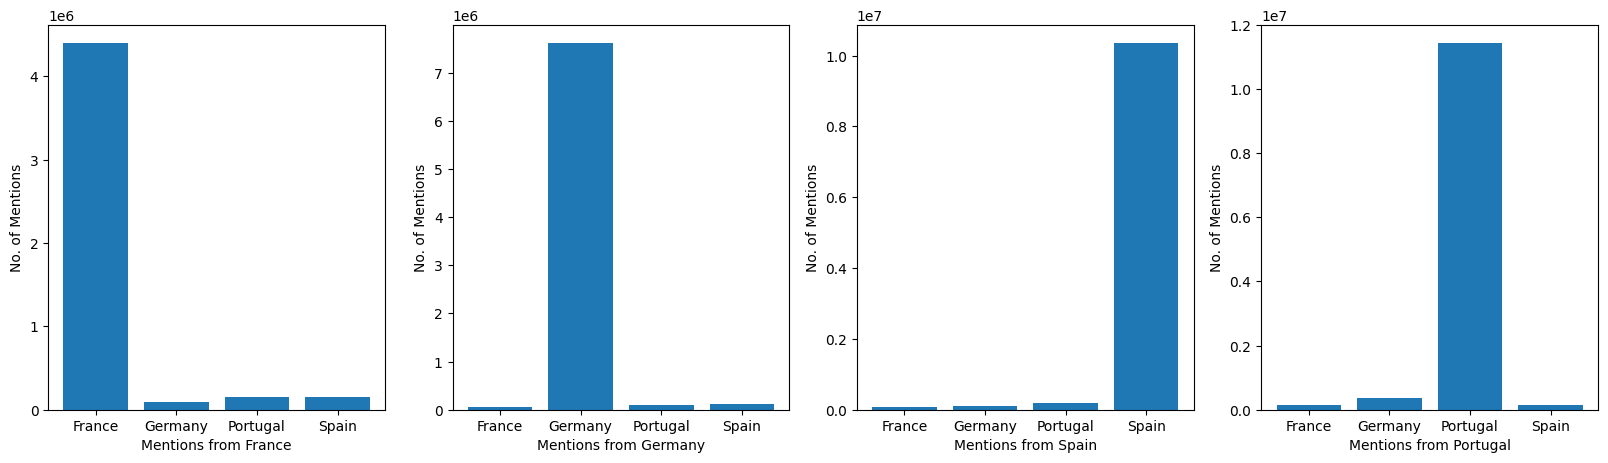

In [20]:
# Graph the number of cross mentions
fig , axes = plt.subplots(1 , len(country_list) , figsize = (20 , 5))

for _ , (ax , user) in enumerate(zip(axes , country_list)):
    df = x_mentions_df_3.loc[user]
    ax.bar(df.index , df.occr);
    ax.set_xlabel(f'Mentions from {user}')
    ax.set_ylabel('No. of Mentions');

# Countries seem to mostly be mentioning themselves